# Tiling From Scratch


* **Last Modified**: 10-03-2021
* **Authors**: Satyarth Praveen, J. Emmanuel Johnson, Nadia Ahmed, Nicholas Roth
---
#### Brief Description

In this notebook, we will explore some ways that we can do *tiling* that are necessary for machine learning purposes as well as visualization.  Often times we have images which are absolutely massive and we need to take bits and pieces to be ingested to other models. Obviously visualization is a different. So it does the following:

1. It makes things easier to handle
2. It makes it possible for ML.

Here we do a simple example for how this works.

---
#### TLDR

> Tiling is a critical component of grabbing images. 

> It uses the WorldFloodsDatasetTiled class that internally tiles the input image and masks. Objects of this class can also be initialized with the transformations to apply transformation to the tiled samples.

> This is useful because it complies with the pytorch datasets that can directly be used for training models.
---

---
#### More Information

* [Tiling](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html)

In [1]:
# Helpful trick for loading the directories correction
import sys, os
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))


from src.data.worldfloods.dataset import WorldFloodsDataset

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Demo Image

For this demonstration, we need a S2 AND a groundtruth image. We have two that we can download.

In [2]:
from src.data.worldfloods.dataset import WorldFloodsImage
from src.data.worldfloods.download import download_image, get_image_path
from src.data.utils import download_data_from_bucket
from pathlib import Path

gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "01042016_Holmes_Creek_at_Vernon_FL.tif"


# ============
# DATAIMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_image_example = WorldFloodsImage(filename=file_name)

# to see
print(dc_image_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/S2")
download_image(dc_image_example, destination_dir)


# ============
# GROUND TRUTH IMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_gt_example = WorldFloodsImage(filename=file_name)
print(dc_gt_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/gt")
download_image(dc_gt_example, destination_dir)

WorldFloodsImage(filename='ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 19, 12, 14, 45, 417970), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2' Is Already There.
WorldFloodsImage(filename='ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 19, 12, 14, 45, 417970), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt' Is Already There.


In [3]:
!ls $destination_dir

01042016_Holmes_Creek_at_Vernon_FL.tif


## Outline the Immediate Steps

* check for file correspondence between the directories

## Initialize PyTorch Dataset

In [4]:
import os
import random
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import numpy as np
import rasterio
import rasterio.windows
from torch.utils.data import Dataset

from src.data.utils import check_path_exists
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS
from src.data.worldfloods.prepare_data import prepare_data_func


from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict



class WorldFloodsDataset(Dataset):
    """
    A dataloader for the WorldFloods dataset.

    Args:
        image_files (List[str]): size of the tiling window
        image_prefix (str): the subdirectory name for the images
        gt_prefix (str): the subdirectory name for the groundtruth
        
    Attributes:
        
    """
    def __init__(
        self,
        image_files: List[str],
        image_prefix: str = "/images/",
        gt_prefix: str = "/gt/",
    ):

        self.image_files = image_files
        self.image_prefix = image_prefix
        self.gt_prefix = gt_prefix

        # sort to make sure that the order is deterministic
        # (order of the flow of data points to the ML model)
        # TODO: Do this for the list of filepaths at the end as well
        self.image_files.sort()




In [5]:
image_files = [
    str(Path(root).joinpath("datasets/trials/image/S2/01042016_Holmes_Creek_at_Vernon_FL.tif")),
]

train_dataset = WorldFloodsDataset(
    image_files=image_files,
)
type(train_dataset)

__main__.WorldFloodsDataset

## 1 - Open Image

First, we can access the rasterio dataset and get access to some of the attributes. The most important one for now is the `height` and `width`.

**Source**: [StackOverFlow](https://gis.stackexchange.com/questions/285499/how-to-split-multiband-image-into-image-tiles-using-rasterio)

In [6]:
with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    print(dataset)
    print(type(dataset))
    print(f"Height: {dataset.meta['height']}")
    print(f"Width: {dataset.meta['width']}")

<open DatasetReader name='gs://ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif' mode='r'>
<class 'rasterio.io.DatasetReader'>
Height: 1980
Width: 2841


### Visualize Image

We can use the tried and true rasterio.

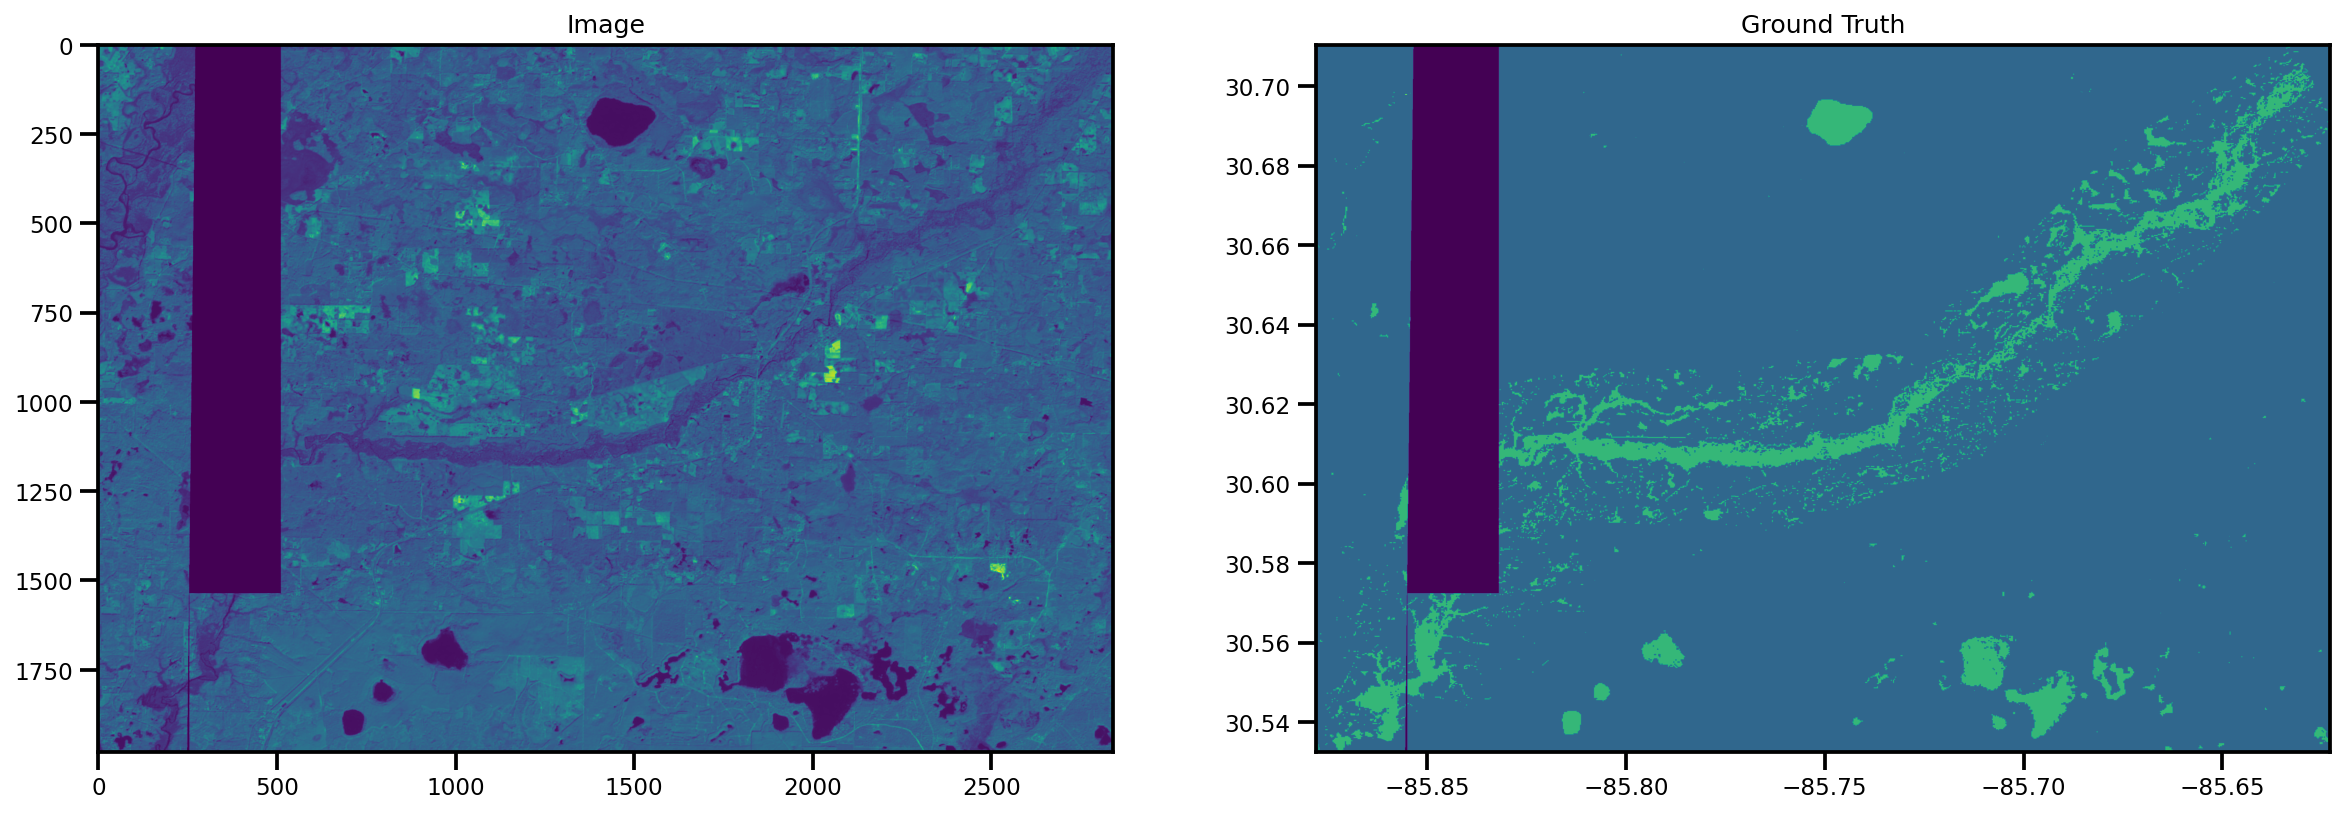

In [7]:
from rasterio.plot import show as rasterio_show

band = 6 # it shows better land features

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    rasterio_show(
        dataset.read(indexes=band), ax=ax[0],)
    ax[0].set_title("Image",)

with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    rasterio_show(dataset, ax=ax[1])
    ax[1].set_title("Ground Truth",)
    
plt.show()

## Tiling

For ML, often we want to use a subset of the original image, aka tiles. For our purposes, we're going to be tiling indiscriminantly, i.e. we are not concerned about geocoordinates. All we care about is that the windowsize is smaller then the images.

### Quick Demo

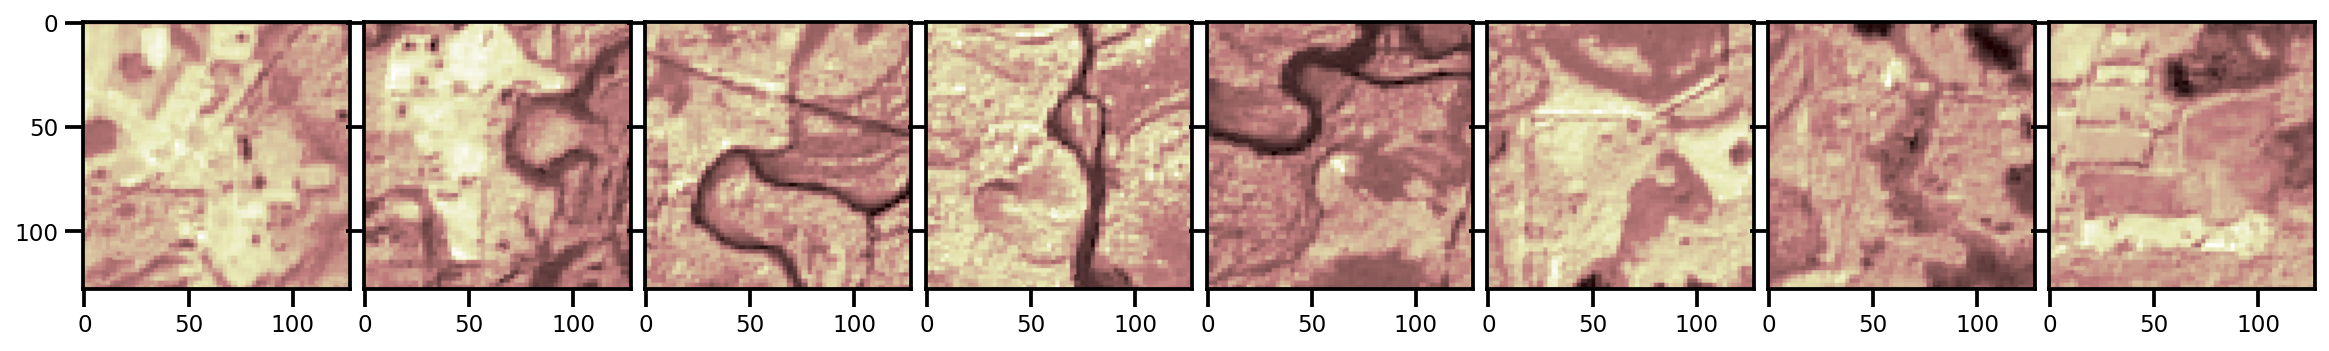

In [8]:
from src.preprocess.tiling import get_window_tiles
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 8
iteration = 0

# plot preamble
fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, n_tiles),
    axes_pad=0.1,
)


# BANDS
bands = [6,] #CHANNELS_CONFIGURATIONS["all"]


with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)


        
        if sub_image.shape != (len(bands), 128, 128):
            continue
            
        # display demo image
        rasterio_show(sub_image, ax=iax, cmap="pink")
    
        iteration += 1
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            break

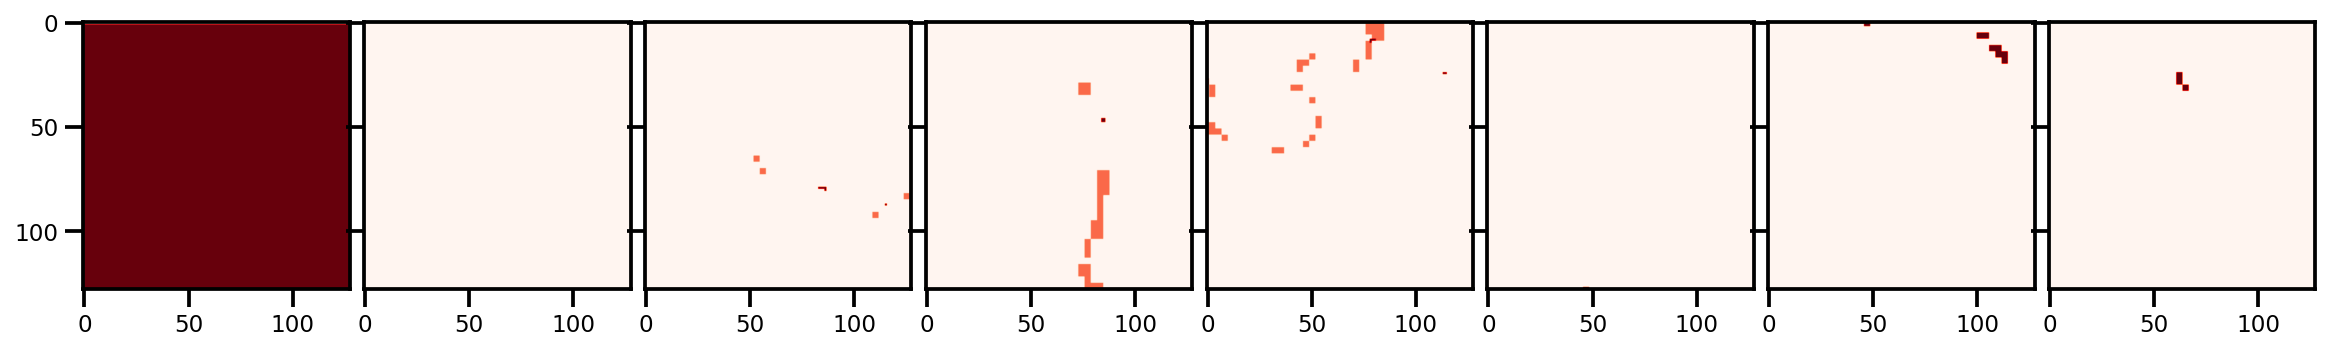

In [9]:
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 8
iteration = 0

fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, n_tiles),
    axes_pad=0.1,
)
bands = [1,]



with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)


        # equal tiling
        if sub_image.shape != (len(bands), 128, 128):
            continue
            
        # display demo image
        rasterio_show(sub_image, ax=iax, cmap="Reds")
    
        iteration += 1
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            break

### Saving the Tiles

##### IMAGES

In [10]:
from src.preprocess.tiling import save_tiles, WindowSize
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS

In [11]:
bands = CHANNELS_CONFIGURATIONS["all"]
bands

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [12]:
%%time
from src.data.utils import create_folder
output_tile_dir = str(Path(root).joinpath("datasets/trials/image/image_tiles/")) 
create_folder(output_tile_dir)
source_img_dir = "gs://"+get_image_path(dc_image_example)
print(source_img_dir)
print(output_tile_dir)

# BANDS
bands = CHANNELS_CONFIGURATIONS["all"]


# WINDOWSIZE
window_size = WindowSize(height=128, width=128)



# dest_dir
save_tiles(source_img_dir, output_tile_dir, bands=bands, window_size=window_size, verbose=False)

Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles' Is Already There.
gs://ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif
/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles
CPU times: user 6.15 s, sys: 1.16 s, total: 7.31 s
Wall time: 19.4 s


In [13]:
!ls $output_tile_dir | head -4

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_100.tif


#### Ground Truth

In [14]:
%%time
from src.data.utils import create_folder
output_tile_dir = str(Path(root).joinpath("datasets/trials/image/gt_tiles/")) 
create_folder(output_tile_dir)
source_img_dir = "gs://"+get_image_path(dc_gt_example)
print(source_img_dir)
print(output_tile_dir)

bands = [1,]
window_size = WindowSize(height=128, width=128)

# dest_dir
save_tiles(source_img_dir, output_tile_dir, bands=bands, window_size=window_size, verbose=False)

Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles' Is Already There.
gs://ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif
/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles
CPU times: user 1.49 s, sys: 529 ms, total: 2.02 s
Wall time: 3.49 s


In [15]:
!ls $output_tile_dir | head -4

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_100.tif


## DataSet (Finally...)

In [16]:
from src.data.worldfloods.dataset import WorldFloodsDataset

In [17]:
from src.data.utils import get_files_in_directory, get_filenames_in_directory

In [18]:
output_image_dir = str(Path(root).joinpath("datasets/trials/image/image_tiles/"))
image_files = get_files_in_directory(output_image_dir, ".tif")

output_gt_dir = str(Path(root).joinpath("datasets/trials/image/gt_tiles/"))
gt_files = get_files_in_directory(output_gt_dir, ".tif")

In [19]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"
pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix)

In [25]:
x, y = pt_ds[50]["image"], pt_ds[50]["mask"]
x.shape, y.shape

((13, 128, 128), (1, 128, 128))

In [26]:
y_ = np.nan_to_num(y)
print(np.sum(np.isnan(y)))
print(np.unique(y))

0
[1 2]


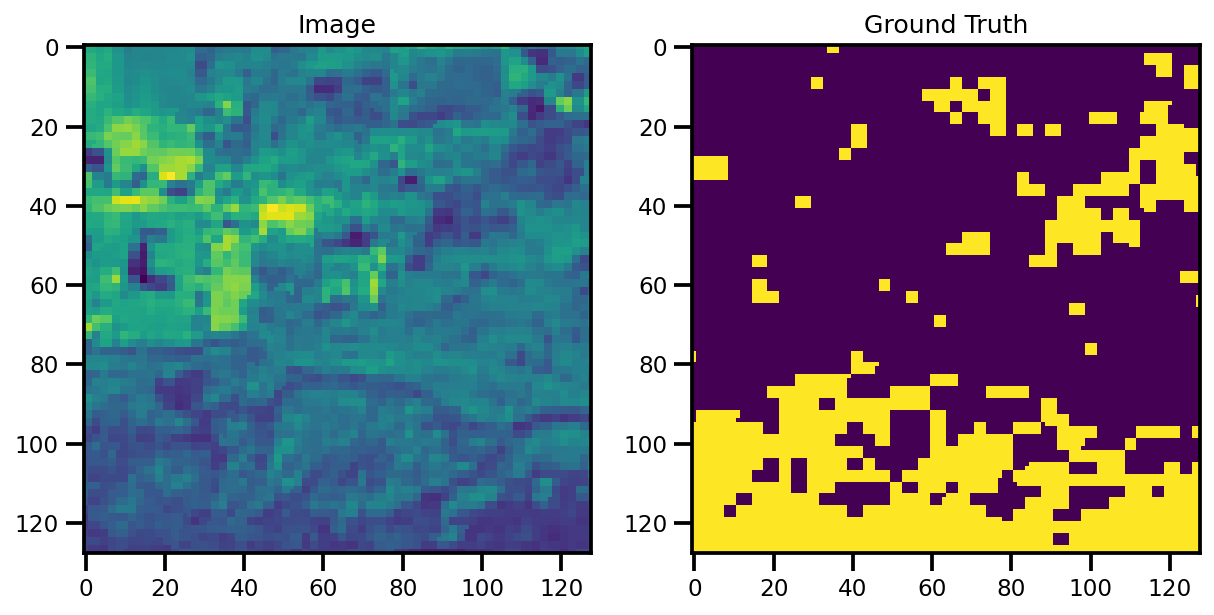

In [27]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)

ax[0].imshow(x[6,:,:].squeeze())
ax[0].set_title("Image")

ax[1].imshow(y.squeeze())
ax[1].set_title("Ground Truth")

plt.show()